# Task 1: Explore  Simulated Muon Data  

We begin with a simplified Monte Carlo (MC) dataset containing muons simulated within the **PDHD detector**.
Familiarize yourself with the data format and event displays to develop an intuitive understanding of the dataset.

- Create plots and analyze features to interpret activity in each readout plane (each APA).
- Identify and distinguish different event topologies (how does the signature of the track change with direction?).
- Examine how Trigger Primitive (TP) properties vary between events and consider possible reasons.
- Compare the response observed in the **collection plane (plane 2)** with that in the **induction planes (planes 0 and 1)**.

As you explore, consider the detector geometry and readout characteristics. Verify whether the observed data behavior aligns with the detector design and expected physical response. Also, note any indications of noise within the data.

In [ ]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES = ["event", "TP_channel", "TP_startT", "TP_peakT", "TP_peakADC", "TP_SADC", "TP_TOT", "TP_plane", "TP_TPC",] #visible signal  - trigger primitives 

#MC-specific branches
MC_BRANCHES = ["event", "Eng", "Px", "Py", "Pz", "P"] #MC information from the particle

#--simulation data containing 100 single muon events in the ProtoDUNE Horizontal Drift Geometry (PDHD)
mc  = load_data("../data/muons_simtps_pdhd_n100.root", MC_BRANCHES, 1000) #MC carlo output 
tps  = load_data("../data/muons_simtps_pdhd_n100.root", TP_BRANCHES, 1000)  #corresponding trigger primitive (TP) information  

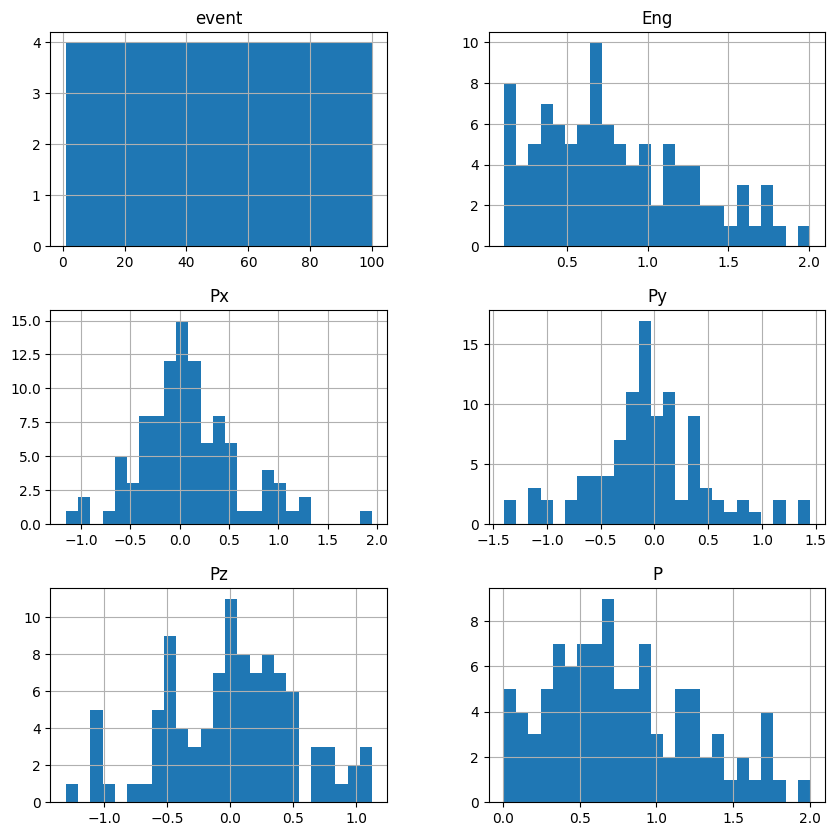

Eng mean: 0.79 and std deviation 0.46.
Px mean: 0.09 and std deviation 0.51.
Py mean: -0.05 and std deviation 0.53.
Pz mean: 0.01 and std deviation 0.53.


In [ ]:
#MC data - note that the energies are in GeV
#Note: these are 100 events in 25 bins 
mc.hist(figsize= (10,10), bins =25)
plt.show()

print(f"Eng mean: {mc['Eng'].mean():.2f} and std deviation {mc['Eng'].std():.2f} GeV.")
print(f"Px mean: {mc['Px'].mean():.2f} and std deviation {mc['Px'].std():.2f} GeV.")
print(f"Py mean: {mc['Py'].mean():.2f} and std deviation {mc['Py'].std():.2f} GeV.")
print(f"Pz mean: {mc['Pz'].mean():.2f} and std deviation {mc['Pz'].std():.2f} GeV.")

Rock filter out lower-energy muons, so only higher-energy muons can penetrate to DUNE.

Px, Py (where x is the drift direction) is roughly simmetrical: no preference between up and down of the PDHD

I'm not sure why the momentum is like that for the z axis -> Is it because there is contamination with cosmics? Are this on Axis? Why is it not forward?

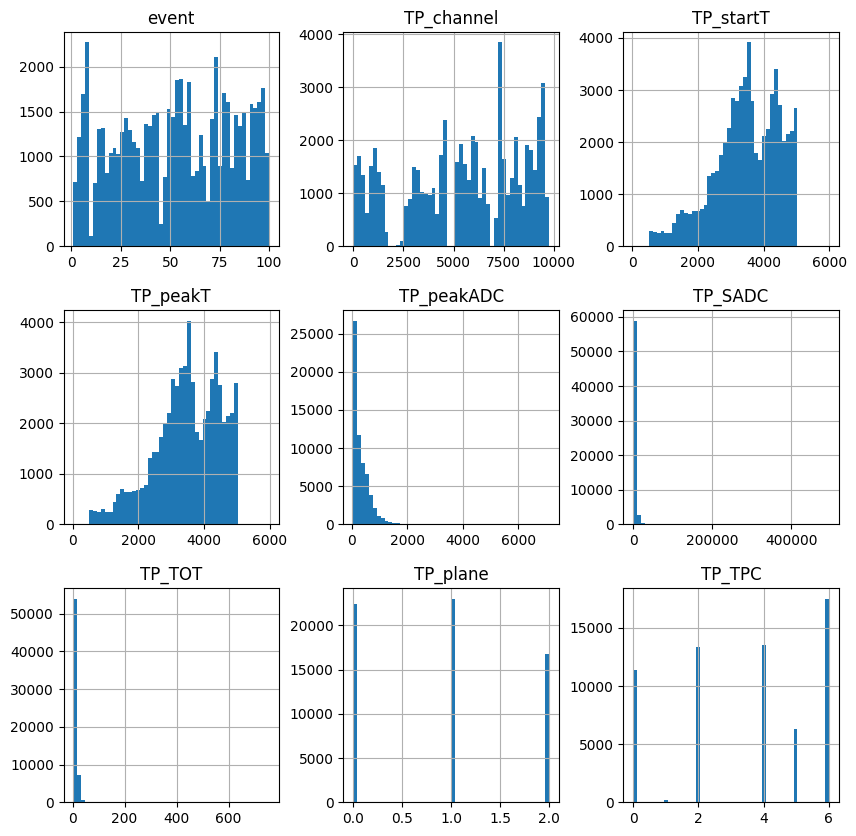

In [17]:
#TP data 
# Refers to the detector's response to simulated events
# This is the data you would "see" in the detector—i.e., the simulated output after the MC truth has passed through the detector simulation and signal processing.

#Collection plane: 960 vertical wires per side
#Induction planes: Two angled wire planes with 800 wires each, wrapping around both sides

tps[tps.TP_TOT>2].hist(figsize= (10,10), bins =50)
plt.show()

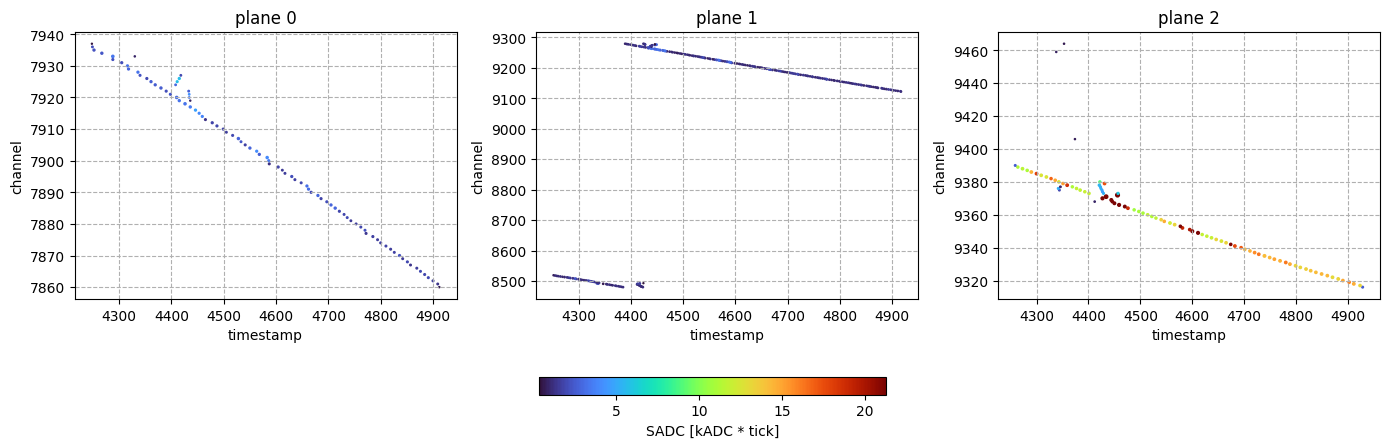

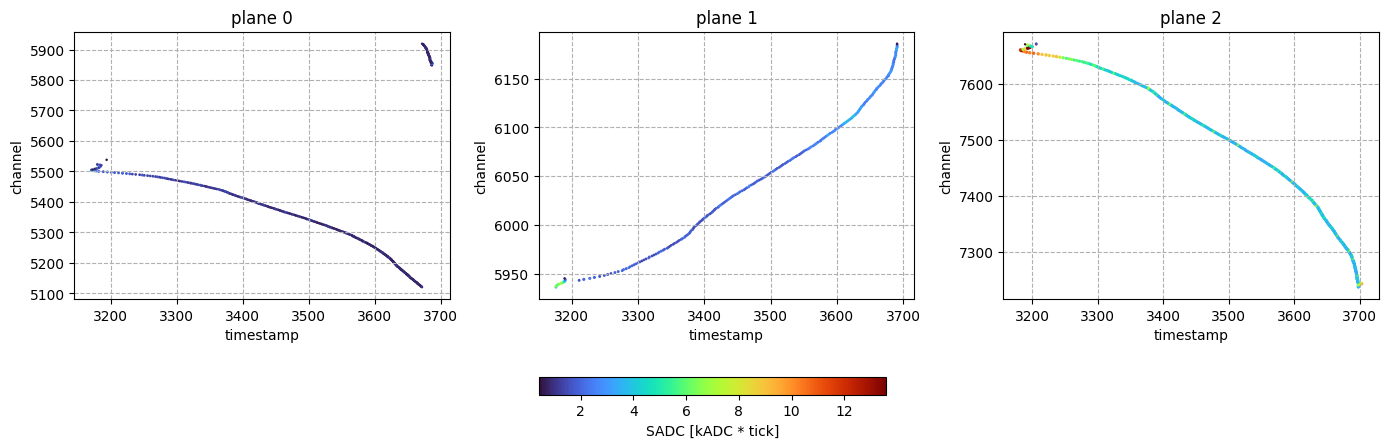

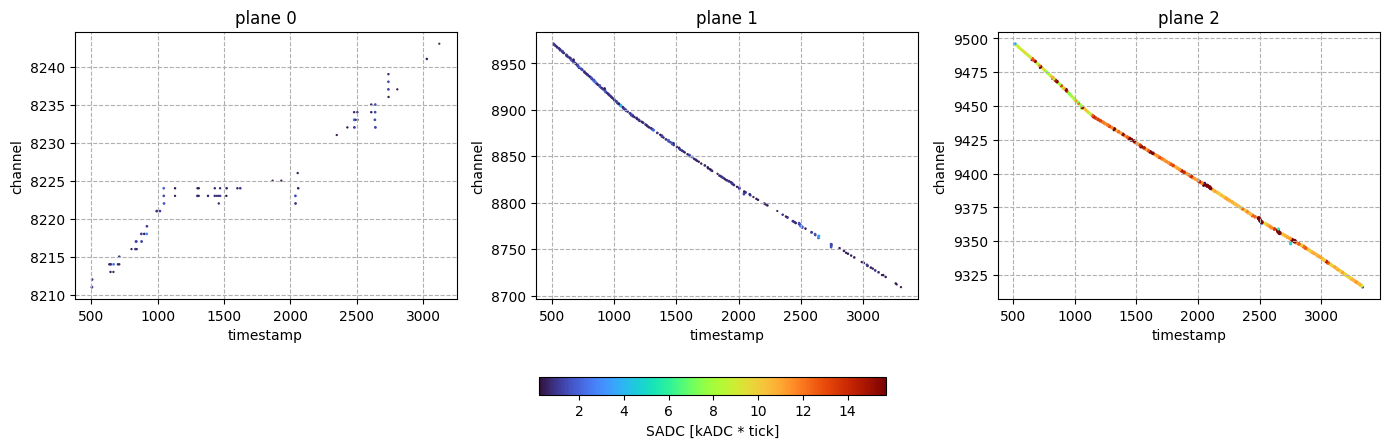

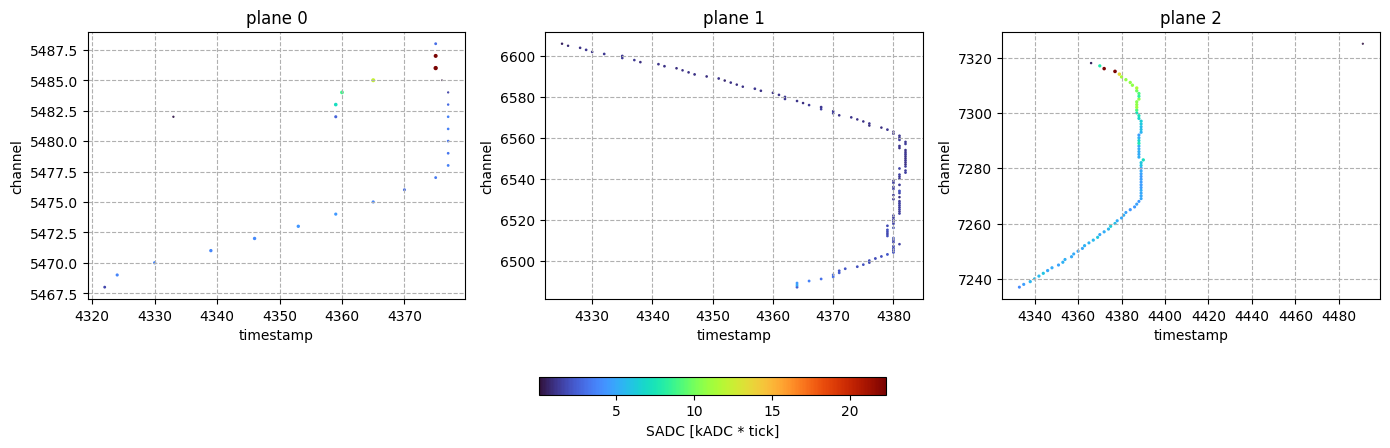

In [34]:
def PlotData(df, event, hit_threshold = 80):
    '''
    A function that let's you plot the trajectory of the muon in time-channel space, as seen within the detector
    increase the hit finding threshold if you're seeing noise in the data

    This cell provides a graphical “event display” for a chosen event, letting you examine the spatial and temporal structure of particle tracks as recorded by the detector’s wire plane
    '''

    tps_all = df[(df.event == event)  & (df.TP_peakADC > hit_threshold)]
    vmin, vmax = tps_all["TP_SADC"].min()/1e3, (tps_all["TP_SADC"].max()/1e3)/2

    fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

    for plane in range(3):
        tps = tps_all[tps_all.TP_plane == plane]
        sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
        ax[plane].set_xlabel("timestamp")
        ax[plane].set_ylabel("channel")
        ax[plane].set_title(f"plane {plane}")
        ax[plane].grid(linestyle='dashed')

    fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
    plt.tight_layout()
    plt.show()

PlotData(tps, 92)
PlotData(tps, 91)
PlotData(tps, 80, hit_threshold=80)  # Adjust hit threshold to reduce noise
PlotData(tps, 60, hit_threshold=80)  # Adjust hit threshold to reduce noise

It makes sense that the SADC is higher on the collector plane.

It also makes sense that the trajectory is about linear and goes through the channels of nearby APAs

You can clearly understand that there are some kind of discretization noises in the event 80. It makes sense that if you put the threshold higher your will reduce sensibly the noise.


In the event 60 it seems to be some sort of curvature

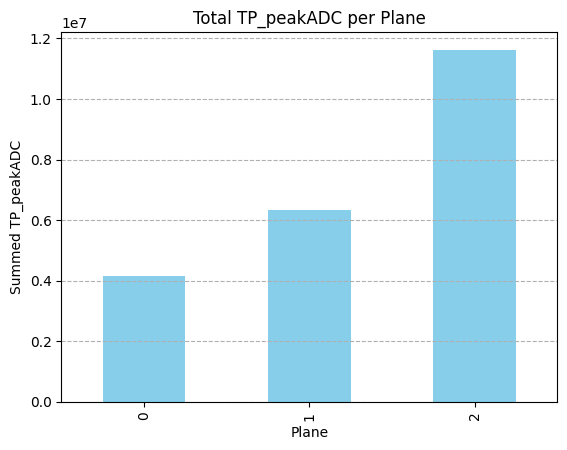

In [24]:
def plot_plane_activity(df):
    """Plot summed TP_peakADC per plane to compare signal strengths."""
    grouped = df[df.TP_peakADC > 80].groupby("TP_plane")["TP_peakADC"].sum()
    grouped.plot(kind='bar', color='skyblue')
    plt.title("Total TP_peakADC per Plane")
    plt.xlabel("Plane")
    plt.ylabel("Summed TP_peakADC")
    plt.grid(axis='y', linestyle='--')
    plt.show()

plot_plane_activity(tps)


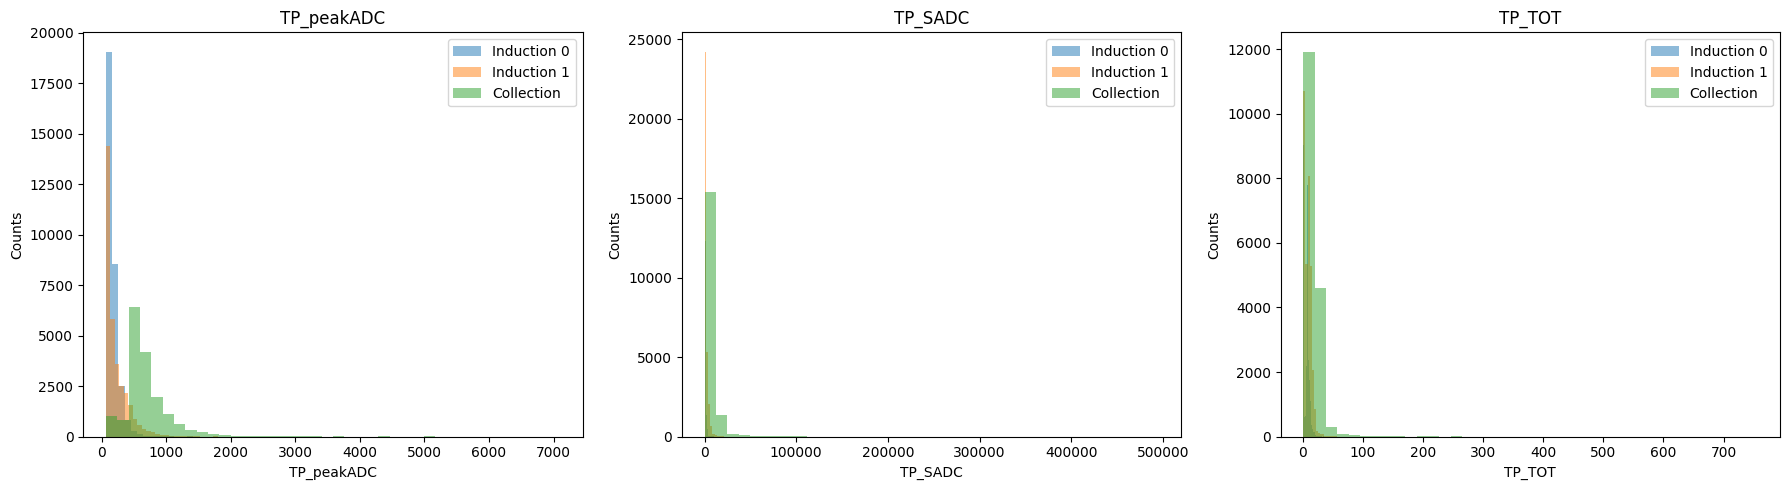

In [20]:
# Plot histograms of TP properties for each plane
plane_labels = {0: "Induction 0", 1: "Induction 1", 2: "Collection"}
properties = ["TP_peakADC", "TP_SADC", "TP_TOT"]

fig, axs = plt.subplots(1, len(properties), figsize=(18, 5))
for i, prop in enumerate(properties):
    for plane in [0, 1, 2]:
        data = tps[tps.TP_plane == plane][prop]
        axs[i].hist(data, bins=40, alpha=0.5, label=plane_labels[plane])
    axs[i].set_title(prop)
    axs[i].set_xlabel(prop)
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_plane_traces(tps):
    """
    Visualizes TP activity for each APA based on TP_channel.
    APA mapping:
        APA1: channels 0–2559
        APA3: channels 2560–5119
        APA2: channels 5120–7679
        APA4: channels 7680–10239
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }
    apa_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    
    # --- Scatter plot: channel vs. TP_peakT for each APA ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for (i, (apa, (start, stop))) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel, 
            s=df_apa.TP_TOT/10, 
            c=df_apa.TP_SADC/1e3, 
            cmap="viridis", 
            alpha=0.7,
            edgecolor="none"
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)
    plt.suptitle("TP Activity per APA (channel vs. time)", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # --- Bar plot: TP count per APA ---
    apa_counts = [
        len(tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]) 
        for (start, stop) in apa_ranges.values()
    ]
    plt.figure(figsize=(8, 5))
    plt.bar(apa_ranges.keys(), apa_counts, color=apa_colors)
    plt.ylabel("Number of TPs")
    plt.title("Total TP Count per APA")
    plt.show()

plot_plane_traces(tps)